## Modelo supervisionado - Clustering

1. Utiliza dataframe pré-processado

In [121]:
import pandas as pd

data = pd.read_csv('data/data-preprocessed.csv')
data

,PESSOA_PIPEDRIVE_id_person,PESSOA_PIPEDRIVE_id_gender,PESSOA_PIPEDRIVE_id_marrital_status,PESSOA_PIPEDRIVE_state,PESSOA_PIPEDRIVE_city,PESSOA_PIPEDRIVE_postal_code,PESSOA_PIPEDRIVE_contract_start_date,PESSOA_PIPEDRIVE_contract_end_date,PESSOA_PIPEDRIVE_Canal de Preferência,PESSOA_PIPEDRIVE_notes_count,...,WHOQOL_Físico_New,WHOQOL_Psicológico_New,WHOQOL_Social_New,WHOQOL_Ambiental_New,COMUNICARE_Problemas Abertos Bool,TWILIO_Data Última Mensagens Inbound Recente,last_stage_concluded,process_time,TWILIO_Data Última Mensagens Outbound Recente,TWILIO_Data Última Ligações Outbound Recente
0,483,64,80,Minas Gerais,Juiz de Fora,36021-600,2021-01-27,2023-08-26,0,3,...,4.0,4.0,4.0,4.5,0,0,Questionário,2022-04-19 15:19:40,1,1
1,860,63,80,Paraná,Londrina,86020-410,2022-06-21,2023-09-20,239,3,...,3.0,3.0,4.0,4.0,1,1,Questionário,2022-06-27 15:03:30,1,0
2,961,63,80,Santa Catarina,Florianópolis,88080-080,2021-07-05,2021-10-01,0,1,...,2.0,3.0,3.0,3.0,0,0,Boas-vindas,2021-10-04 12:25:41,0,0
3,972,63,82,Minas Gerais,Uberlândia,38400-438,2021-06-28,2023-09-16,0,2,...,3.9,3.8,4.3,4.1,1,1,Questionário,2022-05-05 13:14:01,1,0
4,973,64,80,Minas Gerais,Uberlândia,38405-364,2021-06-28,2022-02-07,0,1,...,3.7,3.5,4.0,3.9,0,0,Questionário,2022-02-07 03:00:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,5944,64,80,Paraíba,João Pessoa,58052-310,2023-11-06,NaN,239,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,Em aberto,0,0
968,5948,64,80,Bahia,Salvador,41830-120,2023-11-07,NaN,0,0,...,2.9,2.0,3.0,3.0,1,0,Primeira reunião,Em aberto,0,0
969,5949,64,80,São Paulo,São Paulo,05014-001,2023-11-07,NaN,239,0,...,3.7,3.5,4.0,3.9,0,0,Boas-vindas,Em aberto,0,0
970,5954,63,82,São Paulo,São Paulo,04513-100,2023-11-07,NaN,239,0,...,3.7,4.0,4.0,4.0,0,0,Boas-vindas,Em aberto,0,0


2. Cria coluna de stay_time para utilizar como target, dropa colunas desnecessárias e aplica one hot encoding para as colunas necessárias

In [122]:
from datetime import datetime 
import numpy as np

tempo_permanencia = []

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].items():
    if pd.notna(valor):
        index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].find(";")
        if index != -1:
            data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
    if pd.notna(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"]):
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
    else:
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "PESSOA_PIPEDRIVE_contract_start_date"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))

data['stay_time'] = tempo_permanencia

for indice, valor in data["stay_time"].items():
    index = data.loc[indice, "stay_time"].find(",")
    if index != -1:
        data.loc[indice, "stay_time"] = data.loc[indice, "stay_time"][:index]

data["stay_time"] = data["stay_time"].str.extract('(\d+) days').astype(float)
data["stay_time"] = np.nan_to_num(data["stay_time"], nan=0)

data.drop(columns=["PESSOA_PIPEDRIVE_id_person", "PESSOA_PIPEDRIVE_id_gender","PESSOA_PIPEDRIVE_id_marrital_status","PESSOA_PIPEDRIVE_state", 
                   "PESSOA_PIPEDRIVE_city","PESSOA_PIPEDRIVE_postal_code","PESSOA_PIPEDRIVE_contract_start_date","PESSOA_PIPEDRIVE_contract_end_date",
                   "PESSOA_PIPEDRIVE_Canal de Preferência","FUNIL_ASSINATURA_PIPEDRIVE_id_stage","FUNIL_ASSINATURA_PIPEDRIVE_id_org", "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service","FUNIL_ASSINATURA_PIPEDRIVE_lost_time",
                    "FUNIL_ONBOARDING_PIPEDRIVE_add_time","FUNIL_ONBOARDING_PIPEDRIVE_status","FUNIL_ONBOARDING_PIPEDRIVE_lost_reason", "FUNIL_ONBOARDING_PIPEDRIVE_activities_count",
                     "ATENDIMENTOS_AGENDA_Datas Atendimento Médico", "ATENDIMENTOS_AGENDA_Datas Acolhimento", "ATENDIMENTOS_AGENDA_Datas Prescrição", "last_stage_concluded",
                     "process_time"
                       ], inplace=True)


data = pd.get_dummies(data,columns=["FUNIL_ASSINATURA_PIPEDRIVE_status"], prefix='assinatura_status')
data = pd.get_dummies(data,columns=['FUNIL_ASSINATURA_PIPEDRIVE_lost_reason'], prefix='assinatura_lost_reason')


3. Normaliza os dados

In [123]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

4. Aplica método elbow para encontrar o melhor número de clusterings

c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto

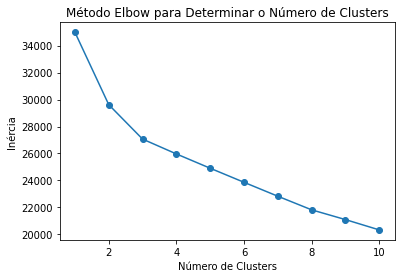

In [124]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plote o gráfico de Elbow
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método Elbow para Determinar o Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

5. Aplica clustering como preditor e gera gráficos com resultados

c:\Users\Julia Paiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


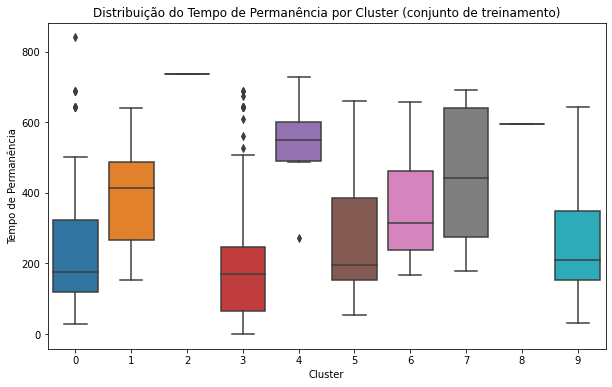

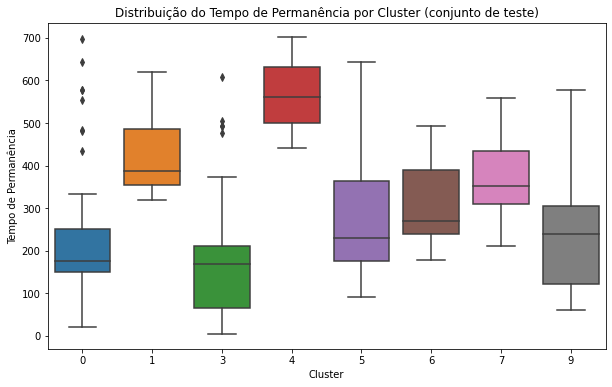

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

X = data.drop(columns=['stay_time'])  
y = data['stay_time']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=10, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_train)

X_test['cluster'] = kmeans.predict(X_test)

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y=data['stay_time'], data=X_train)
plt.title('Distribuição do Tempo de Permanência por Cluster (conjunto de treinamento)')
plt.xlabel('Cluster')
plt.ylabel('Tempo de Permanência')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y=data['stay_time'], data=X_test)
plt.title('Distribuição do Tempo de Permanência por Cluster (conjunto de teste)')
plt.xlabel('Cluster')
plt.ylabel('Tempo de Permanência')
plt.show()
